[View in Colaboratory](https://colab.research.google.com/github/ahracho/CarND-Traffic-Sign-Classifier-Project/blob/master/Traffic_sign_Classifier_batchnorm.ipynb)

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

gpg: keybox '/tmp/tmppzwwkxsd/pubring.gpg' created
gpg: /tmp/tmppzwwkxsd/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
··········


In [2]:
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [3]:
import os
os.path.isdir("drive/DeepLearning/Traffic-Sign-Classifier")

True

## 1. Load Dataset

In [0]:
# Load pickled data
import pickle
import matplotlib.pyplot as plt
import cv2
import numpy as np

# TODO: Fill this in based on where you saved the training and testing data

training_file = "drive/DeepLearning/Traffic-Sign-Classifier/traffic-sign-data/train.p"
validation_file = "drive/DeepLearning/Traffic-Sign-Classifier/traffic-sign-data/valid.p"
testing_file = "drive/DeepLearning/Traffic-Sign-Classifier/traffic-sign-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [5]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

import pandas as pd

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = (X_train.shape[1:])

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(pd.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


## 2. Preprocess Data

In [0]:
# Pre-Processing the data

# scale images to values between -0.5 to 0.5
def preprocess_data(data):
    data_norm = []
    for i in range(len(data)):
        image = data[i]
        image[:,:,0] = cv2.equalizeHist(image[:,:,0])
        image[:,:,1] = cv2.equalizeHist(image[:,:,1])
        image[:,:,2] = cv2.equalizeHist(image[:,:,2])
        image = image/255.-.5
        data_norm.append(image)
    return np.array(data_norm, dtype=np.float32())

X_train = preprocess_data(X_train)
X_valid = preprocess_data(X_valid)
X_test = preprocess_data(X_test)

## 3. Network Design : LeNet with batch normalization

In [0]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

import tensorflow as tf
from tensorflow.contrib.layers import flatten


def LeNet(x, phase):
    # Hyperparameters
    mu = 0
    sigma = 0.1

    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(
        shape=(5, 5, 3, 6), mean=mu, stddev=sigma), name="conv1_W")
    conv1_b = tf.Variable(tf.zeros(6), name="conv1_b")
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[
                         1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.contrib.layers.batch_norm(conv1,
                                 center=True, 
                                 scale=True,
                                 is_training=phase,
                                 updates_collections=None)
    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[
                           1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(
        shape=(5, 5, 6, 16), mean=mu, stddev=sigma), name="conv2_W")
    conv2_b = tf.Variable(tf.zeros(16), name="conv2_b")
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[
                         1, 1, 1, 1], padding='VALID') + conv2_b
    conv2 = tf.contrib.layers.batch_norm(conv2,
                                 center=True, 
                                 scale=True,
                                 is_training=phase,
                                 updates_collections=None)
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[
                           1, 2, 2, 1], padding='VALID')
    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0 = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(
        shape=(400, 250), mean=mu, stddev=sigma), name="fc1_W")
    fc1_b = tf.Variable(tf.zeros(250), name="fc1_b")
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    fc1 = tf.contrib.layers.batch_norm(fc1,
                                 center=True, 
                                 scale=True,
                                 is_training=phase,
                                 updates_collections=None)
    # SOLUTION: Activation.
    fc1 = tf.nn.relu(fc1)
    
    fc2_W = tf.Variable(tf.truncated_normal(
        shape=(250, 120), mean=mu, stddev=sigma), name="fc2_W")
    fc2_b = tf.Variable(tf.zeros(120), name="fc2_b")
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b
    fc2 = tf.contrib.layers.batch_norm(fc2,
                                 center=True, 
                                 scale=True,
                                 is_training=phase,
                                 updates_collections=None)
    # SOLUTION: Activation.
    fc2 = tf.nn.relu(fc2)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc3_W = tf.Variable(tf.truncated_normal(
        shape=(120, 84), mean=mu, stddev=sigma), name="fc3_W")
    fc3_b = tf.Variable(tf.zeros(84), name="fc3_b")
    fc3 = tf.matmul(fc2, fc3_W) + fc3_b
    fc3 = tf.contrib.layers.batch_norm(fc3,
                                 center=True, 
                                 scale=True,
                                 is_training=phase,
                                 updates_collections=None)
    # SOLUTION: Activation.
    fc3 = tf.nn.relu(fc3)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
    fc4_W = tf.Variable(tf.truncated_normal(
        shape=(84, 43), mean=mu, stddev=sigma), name="fc4_W")
    fc4_b = tf.Variable(tf.zeros(43), name="fc4_b")
    logits = tf.matmul(fc3, fc4_W) + fc4_b

    return logits

## 4. Variables Setting

In [0]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
in_training_mode = tf.placeholder(tf.bool)

In [0]:
##### Training Pipeline
rate = 0.001

logits = LeNet(x, in_training_mode)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [0]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

In [0]:
def evaluate(X_data, y_data, is_training):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, in_training_mode:is_training})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## 5. Training & Evaluation

Training...

EPOCH 1 ...
Train Accuracy = 0.666
Validation Accuracy = 0.603
EPOCH 2 ...
Train Accuracy = 0.865
Validation Accuracy = 0.785
EPOCH 3 ...
Train Accuracy = 0.928
Validation Accuracy = 0.839
EPOCH 4 ...
Train Accuracy = 0.956
Validation Accuracy = 0.854
EPOCH 5 ...
Train Accuracy = 0.978
Validation Accuracy = 0.873
EPOCH 6 ...
Train Accuracy = 0.980
Validation Accuracy = 0.892
EPOCH 7 ...
Train Accuracy = 0.982
Validation Accuracy = 0.886
EPOCH 8 ...
Train Accuracy = 0.987
Validation Accuracy = 0.898
EPOCH 9 ...
Train Accuracy = 0.985
Validation Accuracy = 0.897
EPOCH 10 ...
Train Accuracy = 0.987
Validation Accuracy = 0.897
EPOCH 11 ...
Train Accuracy = 0.991
Validation Accuracy = 0.904
EPOCH 12 ...
Train Accuracy = 0.993
Validation Accuracy = 0.905
EPOCH 13 ...
Train Accuracy = 0.995
Validation Accuracy = 0.911
EPOCH 14 ...
Train Accuracy = 0.997
Validation Accuracy = 0.916
EPOCH 15 ...
Train Accuracy = 0.998
Validation Accuracy = 0.918
EPOCH 16 ...
Train Accuracy = 0.999


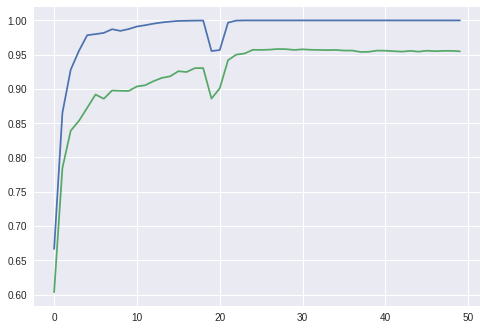

In [12]:
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt

EPOCHS = 50
BATCH_SIZE = 256

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    t_accuracy = []
    v_accuracy = []
    max_va = 0.0
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, len(X_train), BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, in_training_mode: True})
        
        train_accuracy = evaluate(X_train, y_train, False)
        validation_accuracy = evaluate(X_valid, y_valid, False)
        t_accuracy = np.append(t_accuracy, train_accuracy)
        v_accuracy = np.append(v_accuracy, validation_accuracy)
        print("EPOCH {} ...".format(i+1))
        print("Train Accuracy = {:.3f}".format(train_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        
        
        if (validation_accuracy > 0.93) and (validation_accuracy >= max_va):
            saver.save(sess, 'drive/DeepLearning/Traffic-Sign-Classifier/lenet_max')
            print("saved")
            print()
            max_va = validation_accuracy
        
    plt.plot(range(len(t_accuracy)), t_accuracy)
    plt.plot(range(len(v_accuracy)), v_accuracy)
    plt.show()

## 6. Evaluation with Test Dataset

In [13]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('drive/DeepLearning/Traffic-Sign-Classifier'))
    test_accuracy = evaluate(X_test, y_test, False)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from drive/DeepLearning/Traffic-Sign-Classifier/lenet_max
Test Accuracy = 0.933


In [0]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.


### Load Test images and concat them as (n X 32 X 32 X 3) ndarray
import os
import matplotlib.image as mpimg

test_images = os.listdir("drive/DeepLearning/Traffic-Sign-Classifier/test-images")
test_images.sort()

X_final_test = np.empty((0, 32, 32, 3), int)
y_final_test = np.array([22, 28, 14, 4, 31])

for image_name in test_images:
    img = mpimg.imread('drive/DeepLearning/Traffic-Sign-Classifier/test-images/'+image_name)
    X_final_test = np.append(X_final_test, [img], axis=0)
#     img.squeeze()
#     plt.figure(figsize=(1,1))
#     plt.imshow(img)

In [15]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
import tensorflow as tf
sess = tf.Session()
saver.restore(sess, tf.train.latest_checkpoint('drive/DeepLearning/Traffic-Sign-Classifier'))

### preprocess
X_final_test = X_final_test.astype(np.uint8)
X_final_test = preprocess_data(X_final_test)

### Prediction
logit = sess.run(logits, feed_dict={x: X_final_test, in_training_mode:False})
predict = tf.argmax(logit, 1)

for index in range(len(X_final_test)):
    print("Label    : ", y_final_test[index])
    print("Predict : ", sess.run(predict[index]))
    print("")
    
print("Accuracy : ", sess.run(accuracy_operation, feed_dict={logits:logit, y: y_final_test}))

INFO:tensorflow:Restoring parameters from drive/DeepLearning/Traffic-Sign-Classifier/lenet_max
Label    :  22
Predict :  22

Label    :  28
Predict :  28

Label    :  14
Predict :  14

Label    :  4
Predict :  4

Label    :  31
Predict :  23

Accuracy :  0.8


[22 28 14  4 31]

[[ 5.2909875   0.29211706  0.15521884 -0.20108779 -0.594709  ]
 [ 7.871126    3.0481877   2.9351134   0.90154946  0.3770881 ]
 [ 1.2915757   0.59110034  0.33107793  0.2678371  -0.12503614]
 [ 3.7067835   1.3422179   0.40897995 -0.57957876 -1.2276702 ]
 [ 1.78597     1.4449148   1.2514093   1.0142413   0.28344628]]

[[22 20 28 17 38]
 [28 23 31 20 24]
 [14 34 33  8 18]
 [ 4 24 31  5 25]
 [23 25  3 30  9]]


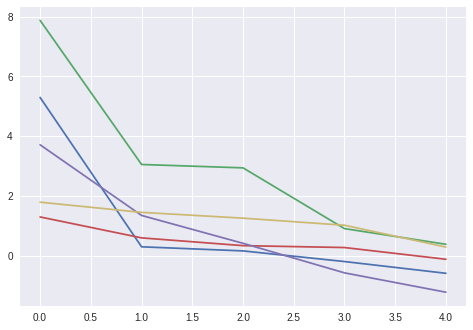

In [16]:

top_k = tf.nn.top_k(logit, k=5, sorted=True)

print(y_final_test)
print("")
print(sess.run(top_k.values))
print("")
print(sess.run(top_k.indices))
top_k_prob = sess.run(top_k.values)

for prob in top_k_prob:
    plt.plot(prob)
sess.close()